In [1]:
# import Liabrary

In [20]:
import random
import pandas as pd
import numpy as np
import os
import cv2
import gc

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models
import torchvision.transforms.functional as F

from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore') 
import torch, gc

from torch.optim  import lr_scheduler

from pycocotools.coco import COCO

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
CFG = {
    'IMG_SIZE':256,
    'EPOCHS':210,
    'LEARNING_RATE':5e-4,
    'BATCH_SIZE':8,
    'SEED':42
}

import wandb

wandb.init(project="pose_estimation_baseline", entity="kimjunsu")

wandb.config = {
  "learning_rate": 5e-4,
  "epochs": 10,
  "batch_size": 8
}

wandb: Currently logged in as: kimjunsu. Use `wandb login --relogin` to force relogin


In [4]:
# seed  fix

In [22]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [150]:
# make dataset test
train_coco_path = '/home/gsc/mmpose/data/coco/annotations/person_keypoints_train2017.json'
valid_coco_path = '/home/gsc/mmpose/data/coco/annotations/person_keypoints_val2017.json'
train_image_folder = '/home/gsc/mmpose/data/coco/train2017'
valid_image_folder = '/home/gsc/mmpose/data/coco/valid2017'

coco = COCO(train_coco_path)
personIds = coco.getCatIds(catNms=['person'])
imgIds = coco.getImgIds(catIds=personIds)
print(imgIds)
annIds = coco.getAnnIds(catIds=personIds,imgIds = imgIds)

anns_test = coco.loadAnns(annIds)

valid_anns_test = []
for ann in anns_test:
    if max(ann['keypoints']) == 0:
        continue
    else:
        valid_anns_test.append(ann)
print(len(valid_anns_test))




loading annotations into memory...
Done (t=3.57s)
creating index...
index created!
[262145, 262146, 524291, 262148, 393223, 393224, 524297, 393227, 131084, 393230, 262161, 131089, 524311, 393241, 524314, 393243, 262171, 131101, 524317, 262175, 524320, 393251, 131108, 524325, 36, 131115, 524333, 262191, 49, 524338, 393267, 393268, 262197, 393271, 262200, 131127, 61, 262207, 393284, 74, 393290, 262221, 524366, 77, 131152, 524373, 262229, 86, 524375, 393306, 262235, 262238, 262239, 262242, 131172, 393317, 131174, 109, 110, 524401, 113, 262260, 393333, 131197, 127, 262273, 262274, 262275, 524420, 136, 131208, 131211, 524428, 262286, 524431, 131215, 524436, 149, 151, 131225, 262299, 393372, 393375, 524450, 165, 524453, 393384, 524459, 131245, 524467, 524470, 524476, 262334, 262335, 192, 262336, 393411, 524486, 201, 393418, 393419, 131276, 131277, 131279, 131280, 262353, 131282, 393428, 262359, 524507, 393438, 393442, 131299, 524522, 524525, 241, 131315, 524533, 262389, 524535, 524536, 26239

427
640


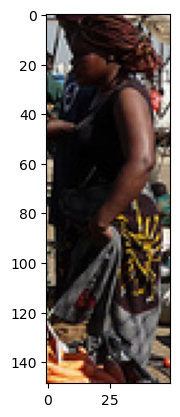

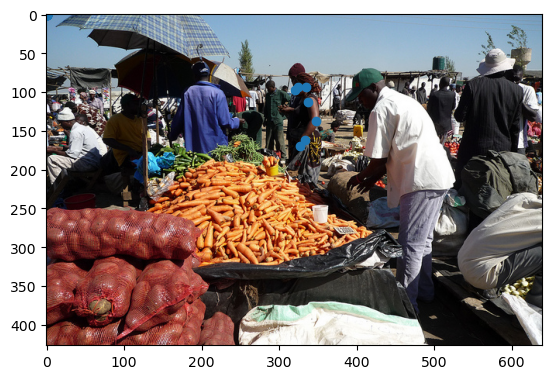

[[320  97]
 [324  93]
 [  0   0]
 [335  93]
 [  0   0]
 [337 112]
 [  0   0]
 [348 137]
 [  0   0]
 [333 161]
 [  0   0]
 [327 170]
 [  0   0]
 [  0   0]
 [  0   0]
 [  0   0]
 [  0   0]]
[[11 20]
 [15 16]
 [ 0  0]
 [26 16]
 [ 0  0]
 [28 35]
 [ 0  0]
 [39 60]
 [ 0  0]
 [24 84]
 [ 0  0]
 [18 93]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]]
[[127.6         43.61592506]
 [255.6          0.        ]
 [126.          41.81733021]
 [255.6          0.        ]
 [121.6         41.81733021]
 [255.6          0.        ]
 [120.8         50.36065574]
 [255.6          0.        ]
 [116.4         61.60187354]
 [255.6          0.        ]
 [122.4         72.39344262]
 [255.6          0.        ]
 [124.8         76.44028103]
 [255.6          0.        ]
 [255.6          0.        ]
 [255.6          0.        ]
 [255.6          0.        ]]


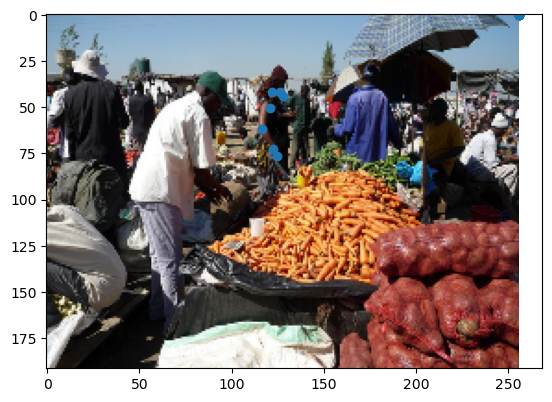

(48, 64)


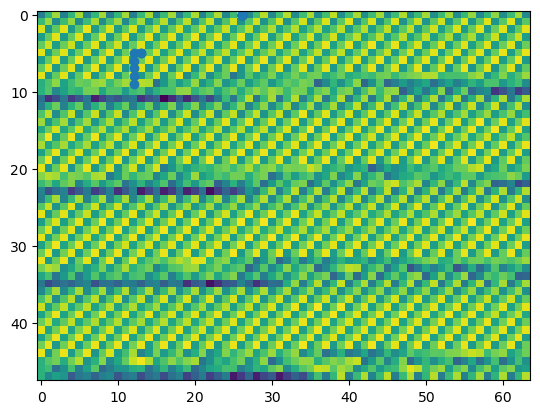

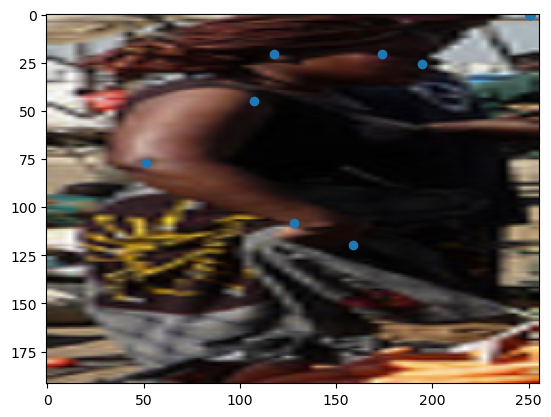

149
50


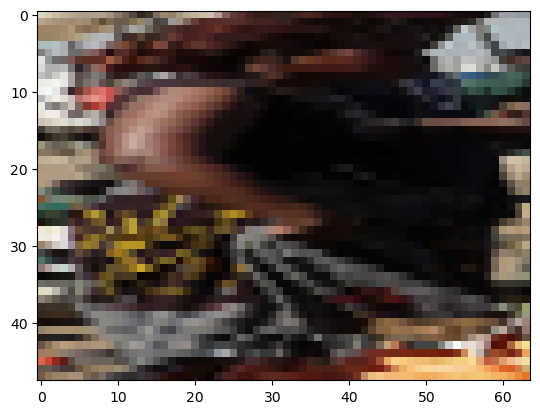

[[194.56        25.77181208]
 [250.88         0.        ]
 [174.08        20.61744966]
 [250.88         0.        ]
 [117.76        20.61744966]
 [250.88         0.        ]
 [107.52        45.10067114]
 [250.88         0.        ]
 [ 51.2         77.31543624]
 [250.88         0.        ]
 [128.         108.24161074]
 [250.88         0.        ]
 [158.72       119.83892617]
 [250.88         0.        ]
 [250.88         0.        ]
 [250.88         0.        ]
 [250.88         0.        ]]
[[49.  6.]
 [63.  0.]
 [44.  5.]
 [63.  0.]
 [29.  5.]
 [63.  0.]
 [27. 11.]
 [63.  0.]
 [13. 19.]
 [63.  0.]
 [32. 27.]
 [63.  0.]
 [40. 30.]
 [63.  0.]
 [63.  0.]
 [63.  0.]
 [63.  0.]]


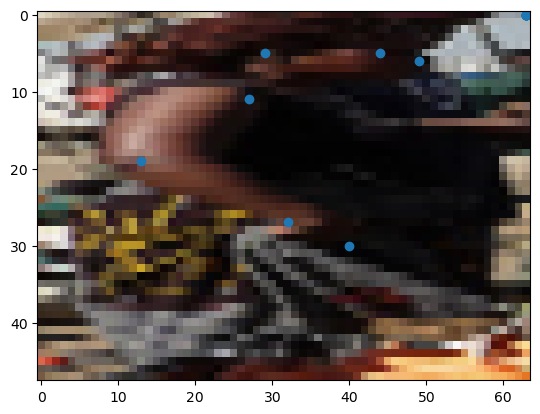

['nose', 'right_eye', 'left_eye', 'right_ear', 'left_ear', 'right_shoulder', 'left_shoulder', 'right_elbow', 'left_elbow', 'right_wrist', 'left_wrist', 'right_hip', 'left_hip', 'right_knee', 'left_knee', 'right_ankle', 'left_ankle']
{'nose': array([49.,  6.]), 'right_eye': array([63.,  0.]), 'left_eye': array([44.,  5.]), 'right_ear': array([63.,  0.]), 'left_ear': array([29.,  5.]), 'right_shoulder': array([63.,  0.]), 'left_shoulder': array([27., 11.]), 'right_elbow': array([63.,  0.]), 'left_elbow': array([13., 19.]), 'right_wrist': array([63.,  0.]), 'left_wrist': array([32., 27.]), 'right_hip': array([63.,  0.]), 'left_hip': array([40., 30.]), 'right_knee': array([63.,  0.]), 'left_knee': array([63.,  0.]), 'right_ankle': array([63.,  0.]), 'left_ankle': array([63.,  0.])}


In [283]:
#for test dataset, dataloader
import matplotlib.pyplot as plt
index = 4
img_id = valid_anns_test[index]['image_id']
img_path = f'{train_image_folder}/{str(img_id).zfill(12)}.jpg'

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_height = image.shape[0]
image_width = image.shape[1]
print(image_height)
print(image_width)

x,y,w,h = valid_anns_test[index]['bbox']
x = int(x+0.5); y = int(y+0.5); w = int(w+0.5); h = int(h+0.5);

cropped_img = image[y:y+h,x:x+w]
plt.imshow(cropped_img)
plt.show()

label = valid_anns_test[index]['keypoints']
label = np.array(label).reshape(-1,3)
keypoints = label[:,:2]
plt.scatter(keypoints[:,0],keypoints[:,1])
plt.imshow(image)
plt.show()
print(keypoints)

cropped_label = keypoints.copy()
cropped_label[:,0] = cropped_label[:,0]-x
cropped_label[:,1] = cropped_label[:,1]-y
cropped_label[cropped_label<0] = 0 

print(cropped_label)
class_labels = [
        "nose",
        "left_eye",
        "right_eye",
        "left_ear",
        "right_ear",
        "left_shoulder",
        "right_shoulder",
        "left_elbow",
        "right_elbow",
        "left_wrist",
        "right_wrist",
        "left_hip",
        "right_hip",
        "left_knee",
        "right_knee",
        "left_ankle",
        "right_ankle"
        ]
transform = A.Compose([
                        #A.HorizontalFlip(p=1),
                        HorizontalFlipEx(p=1),
                        #A.VerticalFlip(p=1),
                        #VerticalFlipEx(p=1),
                        #A.Rotate(border_mode=cv2.BORDER_REPLICATE,p=1,crop_border=False),
                        #A.Rotate(p=1),
                        #A.RandomRotate90(p=1),
                        #A.RandomResizedCrop(height=size, width=size, scale=(0.3, 1.0)),
                        #A.Crop(x_min = x1, y_min = y1, x_max = x2, y_max = y2, always_apply=True, p=1.0)
                        A.Resize(192,256),
                        #A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                        #ToTensorV2(),
                        ], keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels']))
# transform
transformed = transform(image=image, keypoints=keypoints, class_labels = class_labels)
cropped_transformed = transform(image=cropped_img, keypoints=cropped_label, class_labels = class_labels)
transformed_image = transformed['image']
plt.imshow(transformed_image)

transformed_keypoints = np.array(transformed['keypoints'])
print(np.array(transformed_keypoints))
plt.scatter(np.array(transformed_keypoints)[:,0],np.array(transformed_keypoints)[:,1])
plt.show()
transformed_class_labels = transformed['class_labels']
##############################################################################
# reszie 64x48
transformed_keypoints[:,0] = (transformed_keypoints[:,0]*(64/image_width)+0.5).astype(int)
transformed_keypoints[:,1] = (transformed_keypoints[:,1]*(48/image_height)+0.5).astype(int)
transformed_image = np.resize(transformed_image,(48,64))
print(transformed_image.shape)
plt.imshow(transformed_image)
plt.scatter(np.array(transformed_keypoints)[:,0],np.array(transformed_keypoints)[:,1])
plt.show()
##############################################################################
#crop
cropped_transformed_image = cropped_transformed['image']
cropped_transformed_keypoints = np.array(cropped_transformed['keypoints'])
cropped_transformed_class_labels = cropped_transformed['class_labels']
plt.imshow(cropped_transformed_image)
plt.scatter(np.array(cropped_transformed_keypoints)[:,0],np.array(cropped_transformed_keypoints)[:,1])
plt.show()
##############################################################################
cropped_image_height = cropped_img.shape[0]
cropped_image_width = cropped_img.shape[1]

print(cropped_image_height)
print(cropped_image_width)
cropped_resized_transformed_image = cv2.resize(cropped_transformed_image,(64,48))
plt.imshow(cropped_resized_transformed_image)
plt.show()
###############################################################################
print(cropped_transformed_keypoints)
cropped_resized_transformed_keypoints = cropped_transformed_keypoints.copy()
#cropped_resized_transformed_keypoints[:,0] = (cropped_transformed_keypoints[:,0]*(64/cropped_image_width)+0.5).astype(int)
#cropped_resized_transformed_keypoints[:,1] = (cropped_transformed_keypoints[:,1]*(48/cropped_image_height)+0.5).astype(int)
a = dict(zip(cropped_transformed_class_labels, cropped_resized_transformed_keypoints))


cropped_resized_transformed_keypoints[:,0] = (cropped_transformed_keypoints[:,0]*(64/256)+0.5).astype(int)
cropped_resized_transformed_keypoints[:,1] = (cropped_transformed_keypoints[:,1]*(48/192)+0.5).astype(int)

print(cropped_resized_transformed_keypoints)
plt.imshow(cropped_resized_transformed_image)
plt.scatter(np.array(cropped_resized_transformed_keypoints)[:,0],np.array(cropped_resized_transformed_keypoints)[:,1])
plt.show()
print(cropped_transformed_class_labels)
print(a)

In [81]:
class CustomDataset(Dataset):
    def __init__(self, image_folder, label_path, transforms=None):
        self.class_labels = [
        "nose",
        "left_eye",
        "right_eye",
        "left_ear",
        "right_ear",
        "left_shoulder",
        "right_shoulder",
        "left_elbow",
        "right_elbow",
        "left_wrist",
        "right_wrist",
        "left_hip",
        "right_hip",
        "left_knee",
        "right_knee",
        "left_ankle",
        "right_ankle"
        ]
            
        self.transforms = transforms
        
        self.image_folder = image_folder
        self.label_paths = label_path
        self.coco = COCO(label_path)
        personIds = self.coco.getCatIds(catNms=['person'])
        self.imgIds = self.coco.getImgIds(catIds=personIds)
        self.annIds = self.coco.getAnnIds(catIds=personIds,imgIds = self.imgIds)
        
        self.anns = self.coco.loadAnns(self.annIds)
        self.valid_anns = []
        for ann in self.anns:
            if max(ann['keypoints']) == 0:
                continue
            else:
                self.valid_anns.append(ann)
        
    #ann의 길이를 줄이고 시작하기
    def __getitem__(self, index):
        
        # image 불러오기
        img_id = self.valid_anns[index]['image_id']
        img_path = f'{self.image_folder}/{str(img_id).zfill(12)}.jpg'
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # label 불러오기
        label = self.valid_anns[index]['keypoints']
        label = np.array(label).reshape(-1,3)
        keypoints = label[:,:2]
        
        # label의 쓰레기값 찾기
        garbage = np.where(keypoints==0)
        garbage = list(zip(garbage[0],garbage[1]))
        
        # bbox 불러와서 image crop
        x,y,w,h = self.valid_anns[index]['bbox']
        x = int(x+0.5); y = int(y+0.5); w = int(w+0.5); h = int(h+0.5);
        cropped_image = image[y:y+h,x:x+w]
        
        # crop한거 만큼 value 수정
        cropped_keypoints = keypoints.copy()
        cropped_keypoints[:,0] = cropped_keypoints[:,0]-x
        cropped_keypoints[:,1] = cropped_keypoints[:,1]-y
        cropped_keypoints[cropped_keypoints<0] = 0 
        
        # augmentation
        if self.transforms is not None:
            transformed = self.transforms(image=cropped_image, keypoints=cropped_keypoints, class_labels = self.class_labels)
            transformed_image = transformed['image']
            transformed_keypoints = np.array(transformed['keypoints'])
            
        
        # heatmap을 위한 keypoint 수정 (64x48)
        transformed_keypoints[:,0] = (transformed_keypoints[:,0]*(64/256)+0.5).astype(int)
        transformed_keypoints[:,1] = (transformed_keypoints[:,1]*(48/192)+0.5).astype(int)    
        for i in garbage:
            transformed_keypoints[i[0],i[1]] = -10000
        #print(dict(zip(transformed_class_labels ,transformed_keypoints)))        
        return transformed_image, transformed_keypoints
    
    def __len__(self):
        return len(self.valid_anns)


In [82]:
#Augmentation

In [83]:
class HorizontalFlipEx(A.HorizontalFlip):
    swap_columns = [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 16)]

    def apply_to_keypoints(self, keypoints, **params):
        keypoints = super().apply_to_keypoints(keypoints, **params)

        # left/right 키포인트들은 서로 swap해주기
        for a, b in self.swap_columns:
            temp1 = deepcopy(keypoints[a])
            temp2 = deepcopy(keypoints[b])
            keypoints[a] = temp2
            keypoints[b] = temp1

        return keypoints
class VerticalFlipEx(A.VerticalFlip):
    swap_columns = [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 16)]

    def apply_to_keypoints(self, keypoints, **params):
        keypoints = super().apply_to_keypoints(keypoints, **params)

        # left/right 키포인트들은 서로 swap해주기
        for a, b in self.swap_columns:
            temp1 = deepcopy(keypoints[a])
            temp2 = deepcopy(keypoints[b])
            keypoints[a] = temp2
            keypoints[b] = temp1

        return keypoints



In [84]:
def transformation(state='train'):
    if state == 'train':
        transform = A.Compose([
                                HorizontalFlipEx(p=0.2),
                                VerticalFlipEx(p=0.2),
                                A.Rotate(p=1),
                                #A.RandomRotate90(p=0.2),
                                #A.RandomResizedCrop(height=size, width=size, scale=(0.3, 1.0)),
                                #A.Crop(x_min = x1, y_min = y1, x_max = x2, y_max = y2, always_apply=True, p=1.0)
                                A.Resize(192,256),
                                A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                ToTensorV2(),
                                ], keypoint_params=A.KeypointParams(format='xy',remove_invisible=False))
    else:
        transform = A.Compose([
                            A.Resize(192,256),
                            #A.RandomResizedCrop(height=size, width=size, scale=(0.3, 1.0)),               
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

    return transform

In [85]:
train_coco_path = '/home/gsc/mmpose/data/coco/annotations/person_keypoints_train2017.json'
valid_coco_path = '/home/gsc/mmpose/data/coco/annotations/person_keypoints_val2017.json'
train_image_folder = '/home/gsc/mmpose/data/coco/train2017'
valid_image_folder = '/home/gsc/mmpose/data/coco/val2017'

train_transform = transformation('train')
train_dataset= CustomDataset(train_image_folder,train_coco_path,train_transform)
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=False, num_workers=4)

valid_transform = transformation('train')
valid_dataset= CustomDataset(valid_image_folder,valid_coco_path,valid_transform)
valid_loader = DataLoader(valid_dataset, batch_size = 16, shuffle=True, num_workers=4)

loading annotations into memory...
Done (t=3.39s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [80]:
'''
import torchvision.transforms.functional as F
img_id = anns[100]['image_id']
print(img_id)
image_folder = '/home/gsc/mmpose/data/coco/val2017'
img_path = f'{image_folder}/{str(img_id).zfill(12)}.jpg'
print(img_path)
img_test = cv2.imread(img_path)
plt.imshow(img_test)
plt.show()
print(img_path)
print(img_test.shape[0],img_test.shape[1])

x = torch.arange(img_test.shape[1])
y = torch.arange(img_test.shape[0])
yy,xx = torch.meshgrid(y,x)
xx = xx[None,None,:,:].float(); yy = yy[None,None,:,:].float();

anns_array = np.array(anns[100]['keypoints']).reshape(-1,3)
print(anns_array)
x = anns_array[:,0,None,None]; y = anns_array[:,1,None,None]; 
print(f"x shape is : {x.shape}")
print(f"xx shape is : {xx.shape}")
sigma = 10

heatmap = torch.exp(-(((xx-x)/sigma)**2)/2 -(((yy-y)/sigma)**2)/2)
heatmap = heatmap * 255
#heatmap = F.resize(heatmap, (48,64))
plt.imshow(heatmap[0][4])
plt.show()
'''

'\nimport torchvision.transforms.functional as F\nimg_id = anns[100][\'image_id\']\nprint(img_id)\nimage_folder = \'/home/gsc/mmpose/data/coco/val2017\'\nimg_path = f\'{image_folder}/{str(img_id).zfill(12)}.jpg\'\nprint(img_path)\nimg_test = cv2.imread(img_path)\nplt.imshow(img_test)\nplt.show()\nprint(img_path)\nprint(img_test.shape[0],img_test.shape[1])\n\nx = torch.arange(img_test.shape[1])\ny = torch.arange(img_test.shape[0])\nyy,xx = torch.meshgrid(y,x)\nxx = xx[None,None,:,:].float(); yy = yy[None,None,:,:].float();\n\nanns_array = np.array(anns[100][\'keypoints\']).reshape(-1,3)\nprint(anns_array)\nx = anns_array[:,0,None,None]; y = anns_array[:,1,None,None]; \nprint(f"x shape is : {x.shape}")\nprint(f"xx shape is : {xx.shape}")\nsigma = 10\n\nheatmap = torch.exp(-(((xx-x)/sigma)**2)/2 -(((yy-y)/sigma)**2)/2)\nheatmap = heatmap * 255\n#heatmap = F.resize(heatmap, (48,64))\nplt.imshow(heatmap[0][4])\nplt.show()\n'

In [30]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, bn_momentum=0.1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion, momentum=bn_momentum)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, bn_momentum=0.1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
class StageModule(nn.Module):
    def __init__(self, stage, output_branches, c, bn_momentum):
        super(StageModule, self).__init__()
        self.stage = stage
        self.output_branches = output_branches

        self.branches = nn.ModuleList()
        for i in range(self.stage):
            w = c * (2 ** i)
            branch = nn.Sequential(
                BasicBlock(w, w, bn_momentum=bn_momentum),
                BasicBlock(w, w, bn_momentum=bn_momentum),
                BasicBlock(w, w, bn_momentum=bn_momentum),
                BasicBlock(w, w, bn_momentum=bn_momentum),
            )
            self.branches.append(branch)

        self.fuse_layers = nn.ModuleList()
        # for each output_branches (i.e. each branch in all cases but the very last one)
        for i in range(self.output_branches):
            self.fuse_layers.append(nn.ModuleList())
            for j in range(self.stage):  # for each branch
                if i == j:
                    self.fuse_layers[-1].append(nn.Sequential())  # Used in place of "None" because it is callable
                elif i < j:
                    self.fuse_layers[-1].append(nn.Sequential(
                        nn.Conv2d(c * (2 ** j), c * (2 ** i), kernel_size=(1, 1), stride=(1, 1), bias=False),
                        nn.BatchNorm2d(c * (2 ** i), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.Upsample(scale_factor=(2.0 ** (j - i)), mode='nearest'),
                    ))
                elif i > j:
                    ops = []
                    for k in range(i - j - 1):
                        ops.append(nn.Sequential(
                            nn.Conv2d(c * (2 ** j), c * (2 ** j), kernel_size=(3, 3), stride=(2, 2), padding=(1, 1),
                                      bias=False),
                            nn.BatchNorm2d(c * (2 ** j), eps=1e-05, momentum=0.1, affine=True,
                                           track_running_stats=True),
                            nn.ReLU(inplace=True),
                        ))
                    ops.append(nn.Sequential(
                        nn.Conv2d(c * (2 ** j), c * (2 ** i), kernel_size=(3, 3), stride=(2, 2), padding=(1, 1),
                                  bias=False),
                        nn.BatchNorm2d(c * (2 ** i), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    ))
                    self.fuse_layers[-1].append(nn.Sequential(*ops))

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        assert len(self.branches) == len(x)

        x = [branch(b) for branch, b in zip(self.branches, x)]

        x_fused = []
        for i in range(len(self.fuse_layers)):
            for j in range(0, len(self.branches)):
                if j == 0:
                    x_fused.append(self.fuse_layers[i][0](x[0]))
                else:
                    x_fused[i] = x_fused[i] + self.fuse_layers[i][j](x[j])

        for i in range(len(x_fused)):
            x_fused[i] = self.relu(x_fused[i])

        return x_fused

class HRNet(nn.Module):
    def __init__(self, c=48, nof_joints=17, bn_momentum=0.1):
        super(HRNet, self).__init__()

        # Input (stem net)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=bn_momentum, affine=True, track_running_stats=True)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(64, eps=1e-05, momentum=bn_momentum, affine=True, track_running_stats=True)
        self.relu = nn.ReLU(inplace=True)

        # Stage 1 (layer1)      - First group of bottleneck (resnet) modules
        downsample = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=bn_momentum, affine=True, track_running_stats=True),
        )
        self.layer1 = nn.Sequential(
            Bottleneck(64, 64, downsample=downsample),
            Bottleneck(256, 64),
            Bottleneck(256, 64),
            Bottleneck(256, 64),
        )

        # Fusion layer 1 (transition1)      - Creation of the first two branches (one full and one half resolution)
        self.transition1 = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(256, c, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                nn.BatchNorm2d(c, eps=1e-05, momentum=bn_momentum, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
            ),
            nn.Sequential(nn.Sequential(  # Double Sequential to fit with official pretrained weights
                nn.Conv2d(256, c * (2 ** 1), kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
                nn.BatchNorm2d(c * (2 ** 1), eps=1e-05, momentum=bn_momentum, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
            )),
        ])

        # Stage 2 (stage2)      - Second module with 1 group of bottleneck (resnet) modules. This has 2 branches
        self.stage2 = nn.Sequential(
            StageModule(stage=2, output_branches=2, c=c, bn_momentum=bn_momentum),
        )

        # Fusion layer 2 (transition2)      - Creation of the third branch (1/4 resolution)
        self.transition2 = nn.ModuleList([
            nn.Sequential(),  # None,   - Used in place of "None" because it is callable
            nn.Sequential(),  # None,   - Used in place of "None" because it is callable
            nn.Sequential(nn.Sequential(  # Double Sequential to fit with official pretrained weights
                nn.Conv2d(c * (2 ** 1), c * (2 ** 2), kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
                nn.BatchNorm2d(c * (2 ** 2), eps=1e-05, momentum=bn_momentum, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
            )),  # ToDo Why the new branch derives from the "upper" branch only?
        ])

        # Stage 3 (stage3)      - Third module with 4 groups of bottleneck (resnet) modules. This has 3 branches
        self.stage3 = nn.Sequential(
            StageModule(stage=3, output_branches=3, c=c, bn_momentum=bn_momentum),
            StageModule(stage=3, output_branches=3, c=c, bn_momentum=bn_momentum),
            StageModule(stage=3, output_branches=3, c=c, bn_momentum=bn_momentum),
            StageModule(stage=3, output_branches=3, c=c, bn_momentum=bn_momentum),
        )

        # Fusion layer 3 (transition3)      - Creation of the fourth branch (1/8 resolution)
        self.transition3 = nn.ModuleList([
            nn.Sequential(),  # None,   - Used in place of "None" because it is callable
            nn.Sequential(),  # None,   - Used in place of "None" because it is callable
            nn.Sequential(),  # None,   - Used in place of "None" because it is callable
            nn.Sequential(nn.Sequential(  # Double Sequential to fit with official pretrained weights
                nn.Conv2d(c * (2 ** 2), c * (2 ** 3), kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
                nn.BatchNorm2d(c * (2 ** 3), eps=1e-05, momentum=bn_momentum, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
            )),  # ToDo Why the new branch derives from the "upper" branch only?
        ])

        # Stage 4 (stage4)      - Fourth module with 3 groups of bottleneck (resnet) modules. This has 4 branches
        self.stage4 = nn.Sequential(
            StageModule(stage=4, output_branches=4, c=c, bn_momentum=bn_momentum),
            StageModule(stage=4, output_branches=4, c=c, bn_momentum=bn_momentum),
            StageModule(stage=4, output_branches=1, c=c, bn_momentum=bn_momentum),
        )

        # Final layer (final_layer)
        self.final_layer = nn.Conv2d(c, nof_joints, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = [trans(x) for trans in self.transition1]  # Since now, x is a list (# == nof branches)

        x = self.stage2(x)
        # x = [trans(x[-1]) for trans in self.transition2]    # New branch derives from the "upper" branch only
        x = [
            self.transition2[0](x[0]),
            self.transition2[1](x[1]),
            self.transition2[2](x[-1])
        ]  # New branch derives from the "upper" branch only

        x = self.stage3(x)
        # x = [trans(x) for trans in self.transition3]    # New branch derives from the "upper" branch only
        x = [
            self.transition3[0](x[0]),
            self.transition3[1](x[1]),
            self.transition3[2](x[2]),
            self.transition3[3](x[-1])
        ]  # New branch derives from the "upper" branch only

        x = self.stage4(x)

        x = self.final_layer(x[0])

        return x

In [31]:
#model = HRNet(32, 17, 0.1)
#model.load_state_dict(torch.load('./weights/pose_hrnet_w32_256x192.pth'))

In [32]:
#model = HRNet(32, 17, 0.1)
#model = model.to(device)

#y = model(torch.ones(1, 3, 192, 256).to(device))

In [33]:
model = HRNet()
model = model.to(device)
y = model(torch.ones(1,3,192,256).to(device))
print(y.shape)

torch.Size([1, 17, 48, 64])


In [34]:
# Loss Function

In [35]:
def AdapWingLoss(pre_hm, gt_hm):
    # pre_hm = pre_hm.to('cpu')
    # gt_hm = gt_hm.to('cpu')
    theta = 0.5
    alpha = 2.1
    w = 14
    e = 1
    A = w * (1 / (1 + torch.pow(theta / e, alpha - gt_hm))) * (alpha - gt_hm) * torch.pow(theta / e, alpha - gt_hm - 1) * (1 / e)
    C = (theta * A - w * torch.log(1 + torch.pow(theta / e, alpha - gt_hm)))

    batch_size = gt_hm.size()[0]
    hm_num = gt_hm.size()[1]

    mask = torch.zeros_like(gt_hm)
    # W = 10
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    for i in range(batch_size):
        img_list = []
        for j in range(hm_num):
            img_list.append(np.round(gt_hm[i][j].cpu().numpy() * 255))
        img_merge = cv2.merge(img_list).astype('uint8')
        img_dilate = cv2.morphologyEx(img_merge, cv2.MORPH_DILATE, kernel)
        img_dilate[img_dilate < 51] = 1  # 0*W+1
        img_dilate[img_dilate >= 51] = 11  # 1*W+1
        img_dilate = np.array(img_dilate, dtype=np.int)
        img_dilate = img_dilate.transpose(2, 0, 1)
        mask[i] = torch.from_numpy(img_dilate)

    diff_hm = torch.abs(gt_hm - pre_hm)
    AWingLoss = A * diff_hm - C
    idx = diff_hm < theta
    AWingLoss[idx] = w * torch.log(1 + torch.pow(diff_hm / e, alpha - gt_hm))[idx]

    AWingLoss *= mask
    sum_loss = torch.sum(AWingLoss)
    all_pixel = torch.sum(mask)
    mean_loss = sum_loss / all_pixel

    return mean_loss

In [122]:
class JointsMSELoss(nn.Module):
    """MSE loss for heatmaps.

    Args:
        use_target_weight (bool): Option to use weighted MSE loss.
            Different joint types may have different target weights.
        loss_weight (float): Weight of the loss. Default: 1.0.
    """

    def __init__(self, use_target_weight=False, loss_weight=1.):
        super().__init__()
        self.criterion = nn.MSELoss()
        self.use_target_weight = use_target_weight
        self.loss_weight = loss_weight

    def forward(self, output, target, target_weight):
        """Forward function."""
        batch_size = output.size(0)
        num_joints = output.size(1)

        heatmaps_pred = output.reshape(
            (batch_size, num_joints, -1)).split(1, 1)
        heatmaps_gt = target.reshape((batch_size, num_joints, -1)).split(1, 1)

        loss = 0.

        for idx in range(num_joints):
            heatmap_pred = heatmaps_pred[idx].squeeze(1)
            heatmap_gt = heatmaps_gt[idx].squeeze(1)
            if self.use_target_weight:
                loss += self.criterion(heatmap_pred * target_weight[:, idx],
                                       heatmap_gt * target_weight[:, idx])
            else:
                loss += self.criterion(heatmap_pred, heatmap_gt)

        return loss / num_joints * self.loss_weight

In [37]:
def make_heatmap(label):

    x = torch.arange(64)  
    y = torch.arange(48)
    
    yy,xx = torch.meshgrid(y,x) #xx,yy : [48,64]
    
    xx = xx[None,None,:,:].cuda().float(); yy = yy[None,None,:,:].cuda().float(); #xx,yy : [1,1,48,64]
    x = label[:,:,0,None,None].cuda(); y = label[:,:,1,None,None].cuda(); #x,y : [8,17,1,1]
    sigma = 8
    
    heatmap = torch.exp(-(((xx-x)/sigma)**2)/2 -(((yy-y)/sigma)**2)/2) #heatmap: [8,17,48,64]
    #heatmap = F.resize(heatmap, (48,64)).reshape(-1,17,48,64)# [1,17,48,64]
        

    return heatmap

In [110]:
joint_weights=[
    1., 1., 1., 1., 1., 1., 1., 1.2, 1.2, 1.5, 1.5, 1., 1., 1.2, 1.2, 1.5,
    1.5
]
sigmas=[
    0.026, 0.025, 0.025, 0.035, 0.035, 0.079, 0.079, 0.072, 0.072, 0.062,
    0.062, 0.107, 0.107, 0.087, 0.087, 0.089, 0.089
]

In [123]:
def train(model,epochs, optimizer, train_loader, test_loader, scheduler, device):
#def train(model,epochs, optimizer, train_loader, scheduler, device):
    model.to(device)

    #criterion = nn.CrossEntropyLoss().to(device) 바꾸기 adoptivewingloss
    criterion = JointsMSELoss().to(device)
    
    best_score = 100000000
    best_model = None
    
    for epoch in range(1,epochs+1):
        model.train()
        train_loss = []
        for img, label in tqdm(iter(train_loader)):
            
            img, label = img.float().to(device), label.type(torch.LongTensor).to(device) # label heatmap으로 바꿔주기
            #print("train_loader is ready")
            #print(label)
            optimizer.zero_grad()

            model_pred = model(img)
            label = make_heatmap(label) 
            
            #loss = AdapWingLoss(model_pred, label)
            loss = criterion(model_pred, label,sigmas)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        tr_loss = np.mean(train_loss)
        wandb.log({"train_loss": tr_loss})    
        
        val_loss = validation(model, test_loader, device)
        wandb.log({"valid_loss": val_loss})    

        #print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}]')
        #print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val F1 Score : [{val_score:.5f}]')
        print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}]')    
        if scheduler is not None:
            scheduler.step(val_loss)
            
        if best_score > val_loss:
            best_model = model
            best_score = val_loss
            print(f'best_model is : epoch[{epoch}], val_loss[{val_loss}]' )
            
        #if best_score < val_score:
        #    best_model = model
        #    best_score = val_score

        
    return model


In [124]:
def validation(model, test_loader, device):
    model.eval()
    
    model_preds = []
    true_labels = []
    
    val_loss = []
    
    with torch.no_grad():
        for img, label in tqdm(iter(test_loader)):
            img, label = img.float().to(device), label.type(torch.LongTensor).to(device)
            
            model_pred = model(img)
            label = make_heatmap(label) 

            loss = AdapWingLoss(model_pred, label)
            val_loss.append(loss.item())
            
    return np.mean(val_loss)

In [114]:
gc.collect()
torch.cuda.empty_cache()

In [115]:
from copy import deepcopy

In [116]:
#train

In [126]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
#infer_model = train(model,CFG['EPOCHS'], optimizer, train_loader, scheduler, device)
infer_model = train(model,30, optimizer, train_loader, valid_loader, scheduler, device)
#infer_model = train(model,1, optimizer, valid_loader, scheduler, device)

  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.00762] Val Loss : [0.63936]
best_model is : epoch[1], val_loss[0.6393631334118639]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.00766] Val Loss : [0.62268]
best_model is : epoch[2], val_loss[0.6226829139501682]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.00760] Val Loss : [0.60667]
best_model is : epoch[3], val_loss[0.6066740317368687]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.00750] Val Loss : [0.58828]
best_model is : epoch[4], val_loss[0.5882829580108825]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.00745] Val Loss : [0.61697]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.00735] Val Loss : [0.64294]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.00729] Val Loss : [0.63784]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.00726] Val Loss : [0.57201]
best_model is : epoch[8], val_loss[0.5720082722623042]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.00719] Val Loss : [0.72310]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.00715] Val Loss : [0.65545]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.00712] Val Loss : [0.55251]
best_model is : epoch[11], val_loss[0.5525105198474615]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.00709] Val Loss : [0.54277]
best_model is : epoch[12], val_loss[0.5427720666081839]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.00704] Val Loss : [0.57124]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.00697] Val Loss : [0.54235]
best_model is : epoch[14], val_loss[0.5423542081709173]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.00695] Val Loss : [0.59500]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.00691] Val Loss : [0.58011]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.00686] Val Loss : [0.66555]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.00683] Val Loss : [0.53518]
best_model is : epoch[18], val_loss[0.5351824956366638]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.00680] Val Loss : [0.64110]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.00677] Val Loss : [1.10724]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.00671] Val Loss : [0.62700]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.00667] Val Loss : [0.58205]
Epoch 00022: reducing learning rate of group 0 to 2.5000e-04.


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.00633] Val Loss : [0.61375]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.00622] Val Loss : [0.59715]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.00620] Val Loss : [0.69102]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.00614] Val Loss : [0.54639]
Epoch 00026: reducing learning rate of group 0 to 1.2500e-04.


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.00600] Val Loss : [0.60833]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.00592] Val Loss : [0.72188]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.00589] Val Loss : [0.66114]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.00585] Val Loss : [0.81031]
Epoch 00030: reducing learning rate of group 0 to 6.2500e-05.


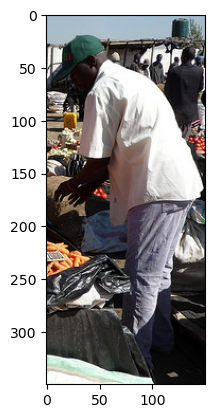

torch.Size([1, 3, 192, 256])
(17, 48, 64)
0.7460231
[10 10]
0.6701046
[ 7 12]
0.13159448
0.7958866
[ 6 17]
0.14771187
0.94074863
[10 21]
0.8388404
[ 9 34]
0.837343
[19 19]
0.5167464
[18 29]
0.71499914
[24 10]
0.61359274
[23 12]
0.89848423
[23 42]
0.8595343
[21 54]
0.89744914
[34 38]
0.82780623
[33 43]
0.8261866
[44 36]
0.77243084
[44 47]


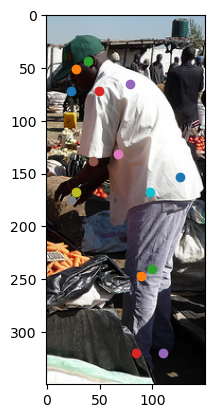

In [164]:
import matplotlib.pyplot as plt
image_test = cv2.imread('/home/gsc/mmpose/data/coco/train2017/000000262145.jpg')#262145
#image_test = cv2.imread(f'/home/gsc/mmpose/data/coco/train2017/000000{image_id_list[5]}.jpg')#262145
image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
image_test = image_test[50:400,380:530] #150x350
image_test0 = image_test.copy()
plt.imshow(image_test)
plt.show()
transform = A.Compose([
                        A.Resize(192,256), #height : 192, width:192
                        #A.RandomResizedCrop(height=size, width=size, scale=(0.3, 1.0)),               
                        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                        ToTensorV2()
                        ])
image_test = transform(image=image_test)['image'].to(device)
image_test = image_test[None,:,:,:]
print(image_test.shape)
infer_model.to(device)
infer_model.eval()
    
model_preds = []
    
with torch.no_grad():
    model_pred = infer_model(image_test).detach().cpu().numpy()[0]
print(model_pred.shape)
final = 0
plt.imshow(image_test0)

for key in model_pred:
    large = np.max(key)
    print(large)
    if large>=0.5:
        
        y_x = np.where(key==large)
        print(np.array(y_x).flatten())
        plt.scatter(int(y_x[1]*(150/64)),int(y_x[0]*(350/48)))
plt.show()

In [ ]:
#해야할거 : heatmap 생성 방법 바꿔서 1 epoch 돌려보고 200 epoch 돌리기
#         loss 함수 바꿔서 학습 시켜보기          

In [151]:
image_id_list = [262145, 262146, 524291, 262148, 393223, 393224, 524297, 393227, 131084, 393230, 262161, 131089, 524311, 393241, 524314, 393243, 262171, 131101, 524317, 262175, 524320, 393251, 131108, 524325, 36, 131115, 524333, 262191, 49, 524338, 393267, 393268, 262197, 393271, 262200, 131127, 61, 262207, 393284, 74, 393290, 262221, 524366, 77, 131152, 524373, 262229, 86, 524375, 393306, 262235, 262238, 262239, 262242, 131172, 393317, 131174, 109, 110, 524401, 113, 262260, 393333, 131197, 127, 262273, 262274, 262275, 524420, 136, 131208, 131211, 524428, 262286, 524431, 131215, 524436, 149, 151, 131225, 262299, 393372, 393375, 524450, 165, 524453, 393384, 524459, 131245, 524467, 524470, 524476, 262334, 262335, 192, 262336, 393411, 524486, 201, 393418, 393419, 131276, 131277, 131279, 131280, 262353, 131282, 393428, 262359, 524507, 393438, 393442, 131299, 524522, 524525, 241, 131315, 524533, 262389, 524535, 524536, 262391, 262394, 393464, 262399, 257, 524547, 262404, 260, 393478, 131335, 393480, 262407, 524551, 131339, 262413, 262414, 131342, 524557, 524559, 262418, 393489, 131343, 393493, 262425, 393497, 393503, 131361, 524577, 131364, 294, 393511, 131366, 393513, 131373, 131374, 131376, 524594, 524595, 262450, 308, 262454, 524601, 315, 393534, 262463, 262465, 322, 524613, 326, 328, 393544, 262476, 262477, 524623, 393553, 338, 524627, 131418, 131419, 524638, 262495, 131427, 357, 524646, 524645, 360, 262505, 393578, 524651, 262508, 262509, 393575, 524649, 368, 393576, 262514, 370, 393592, 524665, 262521, 393593, 131450, 382, 262528, 262529, 524672, 262531, 524677, 389, 524679, 524681, 131465, 395, 262538, 397, 131470, 131467, 393617, 262545, 524692, 262550, 393629, 524702, 415, 393630, 131487, 131486, 419, 393634, 131493, 131494, 262565, 524709, 262561, 131498, 428, 524718, 393647, 431, 393649, 436, 131511, 393656, 524730, 443, 262588, 446, 393664, 524736, 262594, 131522, 393674, 459, 393675, 262605, 131534, 262603, 393680, 262609, 131539, 393685, 471, 262617, 474, 524766, 393699, 524775, 488, 524777, 393707, 393709, 393710, 262642, 524786, 131572, 393714, 524790, 393720, 131580, 131581, 510, 524799, 393724, 262658, 524802, 131589, 393735, 520, 131593, 393738, 131597, 262670, 393743, 262672, 529, 262673, 531, 532, 524819, 536, 131611, 131612, 262686, 542, 544, 131617, 524830, 262688, 262692, 131621, 524844, 262703, 393777, 262705, 262707, 564, 262710, 569, 262715, 572, 262718, 262724, 131661, 589, 524877, 393809, 262738, 131665, 524887, 524889, 262746, 131674, 262747, 131678, 524897, 393826, 393837, 623, 625, 131697, 262770, 393845, 131703, 634, 524924, 524925, 393852, 641, 524929, 262786, 131721, 393874, 659, 524946, 131735, 262810, 524956, 524957, 131742, 131743, 673, 524962, 524966, 393896, 393900, 684, 393905, 690, 524979, 692, 693, 393909, 524983, 131764, 524984, 131763, 393915, 524992, 262848, 131780, 393924, 716, 262861, 262862, 722, 723, 525012, 262869, 393942, 393943, 131800, 262873, 730, 731, 131804, 525021, 525015, 735, 525024, 393954, 525027, 262884, 131812, 131815, 131816, 262893, 525039, 131825, 393971, 761, 525050, 131833, 764, 262909, 393978, 393984, 131840, 525058, 393985, 262917, 131847, 781, 393997, 262925, 131856, 394002, 525075, 790, 262935, 131865, 795, 131869, 525085, 525087, 394019, 262951, 262952, 810, 262956, 525100, 525104, 394033, 525106, 821, 262967, 828, 131902, 831, 525119, 262976, 394050, 836, 262980, 525124, 839, 131909, 131913, 394058, 131915, 131911, 131918, 131919, 262991, 394071, 131927, 263006, 394079, 131937, 525153, 263011, 131942, 525162, 525163, 525169, 525170, 525171, 263028, 882, 263031, 394104, 131961, 525179, 525180, 525183, 525184, 131969, 131967, 263041, 263043, 394113, 901, 897, 131976, 263042, 525187, 131979, 263052, 131978, 913, 525202, 525206, 923, 525211, 394139, 925, 927, 132000, 263073, 525218, 525212, 394149, 934, 394151, 525226, 525227, 263083, 263084, 943, 525232, 132019, 525236, 263094, 132024, 263098, 394172, 263101, 263104, 525249, 962, 960, 965, 132038, 263111, 969, 132042, 394185, 974, 394190, 525264, 525266, 394197, 984, 985, 525273, 132057, 263136, 394209, 394210, 132067, 394214, 999, 263146, 132077, 1006, 525297, 1011, 525300, 1014, 525303, 263163, 394240, 394242, 132099, 394245, 394246, 132102, 263176, 263177, 394248, 394251, 525318, 132114, 263189, 132120, 394266, 1053, 525344, 263202, 132132, 132136, 263208, 525354, 132137, 263212, 394283, 394286, 132143, 525360, 132141, 132147, 263223, 525369, 525373, 263229, 394303, 1089, 525381, 525382, 1098, 1102, 525391, 394320, 394322, 263251, 1107, 394325, 132182, 1108, 263258, 525405, 525409, 263265, 132196, 263270, 263275, 394349, 263278, 132212, 394359, 1144, 1145, 1146, 132219, 263292, 1149, 132217, 525439, 132223, 525438, 525450, 1164, 1176, 394393, 263323, 1180, 525467, 1183, 263328, 263327, 132258, 394404, 132265, 394412, 394415, 132272, 1200, 394418, 1204, 263351, 263355, 525501, 263358, 263359, 132288, 1216, 263362, 394436, 132294, 525510, 525513, 132298, 132299, 394444, 525518, 394447, 1232, 394449, 263377, 132307, 1237, 132310, 263383, 263381, 263385, 1244, 394460, 525533, 263388, 525539, 394468, 525542, 132328, 525546, 394474, 263406, 132336, 394480, 525555, 1270, 1271, 394486, 263418, 525567, 263428, 394501, 525572, 1290, 1292, 525580, 1295, 263440, 1298, 394514, 525589, 394518, 263450, 1307, 1308, 263453, 1311, 394527, 394529, 132386, 1315, 394532, 394533, 132385, 394535, 1319, 132393, 263462, 394539, 132395, 132394, 525616, 1330, 525619, 1332, 394547, 525622, 132406, 394546, 394554, 132412, 1342, 394560, 525636, 394565, 1350, 525640, 394572, 132430, 1359, 1360, 263505, 263504, 394580, 394583, 263512, 1369, 263516, 525660, 394590, 1375, 525666, 525667, 394596, 1381, 525668, 263526, 394600, 525675, 525678, 1390, 394608]